In [1]:
import IPython
import ipywidgets as widgets
from random import Random
import tempfile
import urllib.request
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.io
import skimage.data

In [2]:
random = Random(42)  # Para reproducibilidad; cambiar para obtener distintos resultados

# 1. Introducción al procesamiento de imágenes

## Imágenes digitales y su representación

Una imagen digital es una representación bidimensional de una escena visual.
La imagen se representa como una matriz de **píxeles** (*picture elements*), 
donde cada píxel es un número que representa el color de la imagen en una
posición específica.

z es una matriz de (256, 256) elementos de tipo float64
z tiene valores 0.0866 ± 0.28 en el rango [-0.686, 1.06]
Paletas disponibles: ['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_yerg', 'Grays

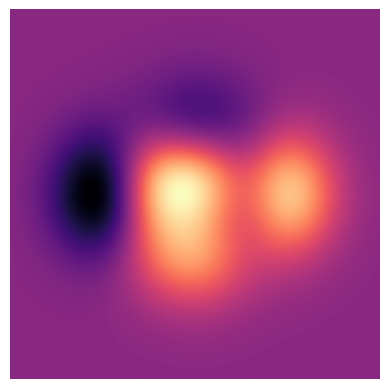

In [3]:
# Generando una imagen a partir de funciones matemáticas
ticks = np.linspace(-3, 3, 256)
x, y = np.meshgrid(ticks, ticks)
z = (1 - x / 2 + x**5 + y**3) * np.exp(-(x**2) - y**2)

print(f"z es una matriz de {z.shape} elementos de tipo {z.dtype}")
print(
    f"z tiene valores {z.mean():.3} ± {z.std():.3} "
    f"en el rango [{z.min():.3}, {z.max():.3}]"
)
print("Paletas disponibles:", plt.colormaps())

fig, ax = plt.subplots()
im = ax.imshow(z, cmap='magma')
ax.set_axis_off()

El Instituto de Procesamiento de Señales e Imágenes de la Universidad California
del Sur (**USC-SIPI**)  ha creado una base de datos de imágenes digitales que
puede ser utilizada para propósitos de investigación y educación.
Se puede acceder a la base de datos en el siguiente enlace:
https://sipi.usc.edu/database/

In [5]:
def descargar_sipi(volumen: str, destino: Path = Path("sipi")) -> None:
    """Descarga un volumen de la base de datos miscelánea de la USC-SIPI."""
    url = f"https://sipi.usc.edu/database/{volumen}.zip"
    assert volumen in ["textures", "aerials", "misc", "sequences"]
    
    if (destino / volumen).exists():
        print(f"El volumen {volumen} ya existe en el directorio sipi.")
        return
    
    with tempfile.TemporaryFile() as temp:
        print(f"Descargando {url}...")
        temp.write(urllib.request.urlopen(url).read())
        temp.seek(0)
        with zipfile.ZipFile(temp) as z:
            print(f"Descomprimiendo {volumen}.zip...")
            z.extractall(destino)
    
    print(f"Volumen {volumen} descargado y descomprimido en {destino}.")

# Descargamos la base de datos miscelánea de la USC-SIPI
descargar_sipi("misc")

El volumen misc ya existe en el directorio sipi.


In [6]:
imagenes = list(Path("sipi/misc").iterdir())
print(f"Hay {len(imagenes)} imágenes en la base de datos miscelánea.")

Hay 39 imágenes en la base de datos miscelánea.


Mostrando house.tiff...
La imagen es un arreglo de tipo uint8 y de forma (512, 512, 3).
En promedio, sus valores son 155.29 ± 54.85 en el rango [0, 255].
La imagen es a color.


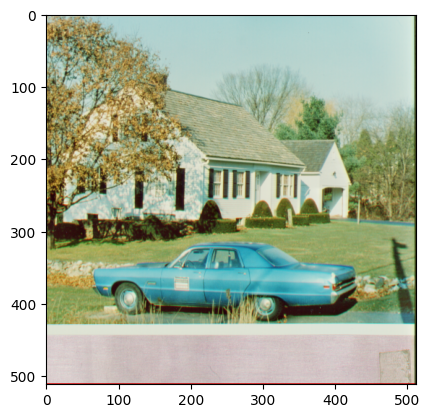

In [7]:
imagen_aleatoria = random.choice(imagenes)
print(f"Mostrando {imagen_aleatoria.name}...")
imagen = plt.imread(imagen_aleatoria)
print(f"La imagen es un arreglo de tipo {imagen.dtype} y de forma {imagen.shape}.")
print(
    f"En promedio, sus valores son {imagen.mean():.2f} ± {imagen.std():.2f} "
    f"en el rango [{imagen.min()}, {imagen.max()}]."
)

# Determinar si la imagen es a color o en escala de grises
a_color = imagen.ndim == 3
if a_color:
    print(f"La imagen es a color.")
else:
    print(f"La imagen es en escala de grises.")

# Mostrar la imagen
fig, ax = plt.subplots()
if a_color:
    img = ax.imshow(imagen)
else:
    img = ax.imshow(imagen, cmap="gray")

## Curvas de Bézier

Una **curva de Bézier** es un tipo de curva paramétrica definida por un
conjunto de **puntos de control**.
Antes de comenzar con la definición formal, vale la pena ver un ejemplo de la
consrucción de una curva de Bézier.

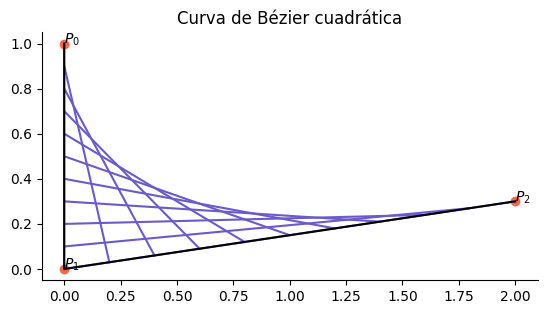

In [8]:
# Definimos tres puntos de control:
puntos = np.array([[0, 1], [0, 0], [2, .3]], dtype=float)

# Interpolamos los tres puntos con dos segmentos de recta:
n_particiones = 11
segmento1 = np.linspace(puntos[0], puntos[1], n_particiones)
segmento2 = np.linspace(puntos[1], puntos[2], n_particiones)

# Creamos la figura y los ejes:
fig, ax = plt.subplots()
ax.set_title("Curva de Bézier cuadrática")
ax.set_aspect("equal")

# Dibujamos cuerdas entre los segmentos de recta:
for p1, p2 in zip(segmento1, segmento2):
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color="slateblue")

# Dibujamos los segmentos de recta:
ax.plot(puntos[:, 0], puntos[:, 1], color="black")

# Dibujamos los puntos de control:
ax.scatter(puntos[:, 0], puntos[:, 1], color="tomato")
for i in range(3):
    ax.annotate(f"$P_{i}$", puntos[i])

# Removemos el eje superior y el derecho:
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)